# SWISS ROLL
#### http://people.cs.uchicago.edu/~dinoj/manifold/swissroll.html

In [1]:
centers = [[7.5, 7.5], [7.5, 12.5], [12.5, 7.5], [12.5, 12.5]]
covariance = [[1, 0], [0, 1]]

In [1]:
import numpy as np

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
h1 = np.random.multivariate_normal(centers[0], covariance, 400)
h2 = np.random.multivariate_normal(centers[1], covariance, 400)
h3 = np.random.multivariate_normal(centers[2], covariance, 400)
h4 = np.random.multivariate_normal(centers[3], covariance, 400)

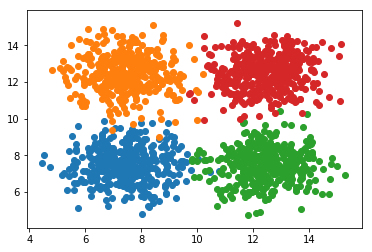

In [18]:
x1, y1 = h1[:, 0], h1[:, 1]
x2, y2 = h2[:, 0], h2[:, 1]
x3, y3 = h3[:, 0], h3[:, 1]
x4, y4 = h4[:, 0], h4[:, 1]
plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.scatter(x3, y3)
plt.scatter(x4, y4)

In [30]:
#(x,y) -> (x cos x, y, x sin x).
Z1, Z2, Z3 = X*np.cos(X), Y, X*np.sin(X)

In [36]:
z11, z12, z13 = x1*np.cos(x1), y1, x1*np.sin(x1)
z21, z22, z23 = x2*np.cos(x2), y2, x2*np.sin(x2)
z31, z32, z33 = x3*np.cos(x3), y3, x3*np.sin(x3)
z41, z42, z43 = x4*np.cos(x4), y4, x4*np.sin(x4)

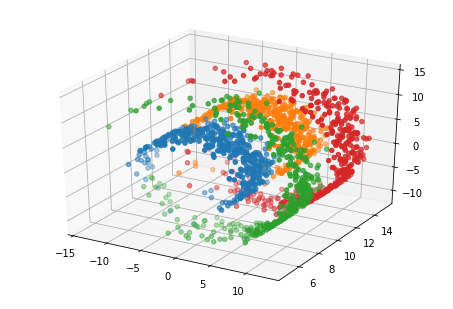

In [37]:
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
fig = plt.figure()

ax = Axes3D(fig)


ax.scatter(z11, z12, z13)
ax.scatter(z21, z22, z23)
ax.scatter(z31, z32, z33)
ax.scatter(z41, z42, z43)
#ax.clabel(cset, fontsize=9, inline=1)
plt.show()

-------------------------

## IMPROVED METHODS FOR WGAN TRAINING
### Paper:https://arxiv.org/abs/1704.00028v3
### Code: https://github.com/igul222/improved_wgan_training

In [1]:
import sklearn.datasets
import numpy as np

In [2]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def get_data(batch_size):
    data = sklearn.datasets.make_swiss_roll(n_samples=batch_size, noise=0.25)[0]
    data = data.astype('float32')[:, [0, 2]]
    data /= 7.5 # stdev plus a little
    return data

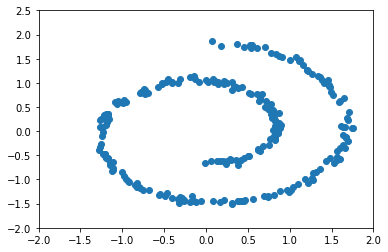

In [33]:
data = get_data(256)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(data[:, 0], data[:, 1])
plt.xlim(-2, 2)
plt.ylim(-2, 2.5)
plt.show()

In [4]:
import tensorflow as tf 

In [5]:
import tflib as lib
import tflib.ops.linear

In [45]:
DIM = 512
BATCH_SIZE = 256
MODE = "wgan"

In [46]:
LAMBDA = 10

In [53]:
def ReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(
        name+'.Linear',
        n_in,
        n_out,
        inputs,
        initialization='he'
    )
    output = tf.nn.relu(output)
    return output

def Generator(n_samples, real_data):
    noise = tf.random_normal([n_samples, 2])
    output = ReLULayer('Generator.1', 2, DIM, noise)
    output = ReLULayer('Generator.2', DIM, DIM, output)
    output = ReLULayer('Generator.3', DIM, DIM, output)
    output = lib.ops.linear.Linear('Generator.4', DIM, 2, output)
    return output

def Discriminator(inputs):
    output = ReLULayer('Discriminator.1', 2, DIM, inputs)
    output = ReLULayer('Discriminator.2', DIM, DIM, output)
    output = ReLULayer('Discriminator.3', DIM, DIM, output)
    output = lib.ops.linear.Linear('Discriminator.4', DIM, 1, output)
    return tf.reshape(output, [-1])

real_data = tf.placeholder(tf.float32, shape=[None, 2])
fake_data = Generator(BATCH_SIZE, real_data)

disc_real = Discriminator(real_data)
disc_fake = Discriminator(fake_data)

# WGAN loss
disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)
gen_cost = -tf.reduce_mean(disc_fake)

# WGAN gradient penalty
if MODE == 'wgan-gp':
    alpha = tf.random_uniform(shape=[BATCH_SIZE,1], minval=0.,maxval=1.)
    interpolates = alpha*real_data + ((1-alpha)*fake_data)
    disc_interpolates = Discriminator(interpolates)
    gradients = tf.gradients(disc_interpolates, [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean((slopes-1)**2)
    disc_cost += LAMBDA*gradient_penalty

disc_params = lib.params_with_name('Discriminator')
gen_params = lib.params_with_name('Generator')

if MODE == 'wgan-gp':
    disc_train_op = tf.train.AdamOptimizer(learning_rate=5e-5, beta1=0, beta2=0.9).minimize(disc_cost, var_list=disc_params)
    gen_train_op = tf.train.AdamOptimizer(learning_rate=5e-5, beta1=0, beta2=0.9).minimize(gen_cost, var_list=gen_params)
else:
    disc_train_op = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(disc_cost, var_list=disc_params)
    gen_train_op = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(gen_cost, var_list=gen_params)

In [48]:
saver = tf.train.Saver()

In [49]:
clip_ops = []
for var in disc_params:
    clip_bounds = [-.01, .01]
    clip_ops.append(tf.assign(var, tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])))
    clip_disc_weights = tf.group(*clip_ops)

In [54]:
ITERS = 62000
CRITIC_ITERS = 5

In [55]:
disc_losses = []
gen_losses = []
generations = []

In [56]:
session = tf.Session()
session.run(tf.global_variables_initializer())
#saver.restore(session, "./checkpoint Swiss Roll 40k iterations WGAN/SwissRoll.ckpt")
for iteration in range(ITERS):
    for i in range(CRITIC_ITERS):
        _data = get_data(BATCH_SIZE)
        _disc_cost, _ = session.run([disc_cost, disc_train_op], feed_dict={real_data: _data})
        if MODE != 'wgan-gp':
            _ = session.run([clip_disc_weights])
    disc_losses.append(_disc_cost)
    _gen_cost, _ = session.run([gen_cost, gen_train_op])
    if iteration % 500 == 499:
        print("Iteration:  " + str(iteration) + " Discriminator loss " + str(_disc_cost))
        print("Iteration:  " + str(iteration) + " Generator loss " + str(_gen_cost))
    gen_losses.append(_gen_cost)
    if iteration % 1000 == 999:
        generations.append(session.run(fake_data))

Iteration:  499 Discriminator loss -0.021126721
Iteration:  499 Generator loss 0.012312418
Iteration:  999 Discriminator loss -0.013313818
Iteration:  999 Generator loss 0.012937003
Iteration:  1499 Discriminator loss -0.004669034
Iteration:  1499 Generator loss 0.0004786615
Iteration:  1999 Discriminator loss -0.0023605768
Iteration:  1999 Generator loss 0.007871441
Iteration:  2499 Discriminator loss -0.0025498173
Iteration:  2499 Generator loss -0.00057649694
Iteration:  2999 Discriminator loss -0.0035765502
Iteration:  2999 Generator loss 0.0052671293
Iteration:  3499 Discriminator loss -0.004865574
Iteration:  3499 Generator loss 0.005657153
Iteration:  3999 Discriminator loss -0.0105823055
Iteration:  3999 Generator loss 0.0021910176
Iteration:  4499 Discriminator loss -0.0031171255
Iteration:  4499 Generator loss -0.0012252774
Iteration:  4999 Discriminator loss -0.0042547495
Iteration:  4999 Generator loss 0.002048511
Iteration:  5499 Discriminator loss -0.00068160385
Iteration

Iteration:  42999 Discriminator loss 3.480818e-08
Iteration:  42999 Generator loss -0.001601374
Iteration:  43499 Discriminator loss 2.735993e-06
Iteration:  43499 Generator loss -0.0033374375
Iteration:  43999 Discriminator loss 9.094132e-06
Iteration:  43999 Generator loss -0.003483656
Iteration:  44499 Discriminator loss 2.022367e-05
Iteration:  44499 Generator loss -0.0041629057
Iteration:  44999 Discriminator loss -2.6412774e-05
Iteration:  44999 Generator loss -0.004269346
Iteration:  45499 Discriminator loss 1.06622465e-05
Iteration:  45499 Generator loss -0.004678646
Iteration:  45999 Discriminator loss -1.8242747e-05
Iteration:  45999 Generator loss -0.0068723247
Iteration:  46499 Discriminator loss -1.2298115e-06
Iteration:  46499 Generator loss -0.0061416524
Iteration:  46999 Discriminator loss -1.0903925e-05
Iteration:  46999 Generator loss -0.006662486
Iteration:  47499 Discriminator loss 4.107412e-05
Iteration:  47499 Generator loss -0.012194498
Iteration:  47999 Discrimi

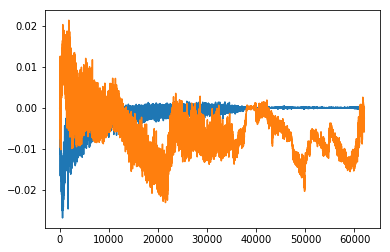

In [11]:
plt.plot(disc_losses)
plt.plot(gen_losses)

In [10]:
disc_losses = np.load('./wgan/disc_losses.npy')
gen_losses = np.load('./wgan/gen_losses.npy')

In [58]:
len(generations)

62

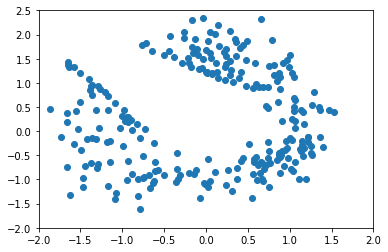

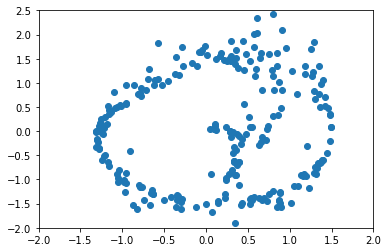

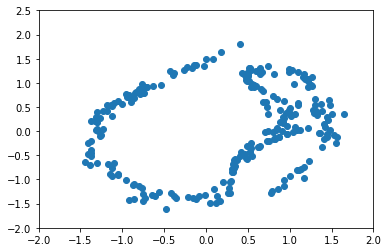

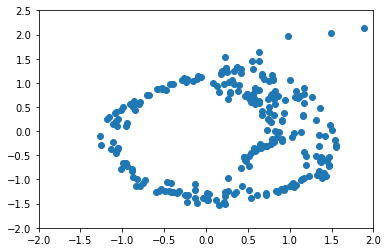

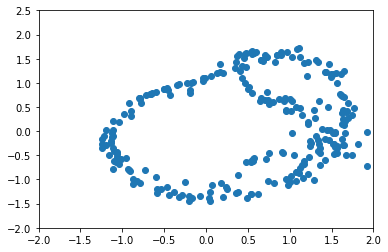

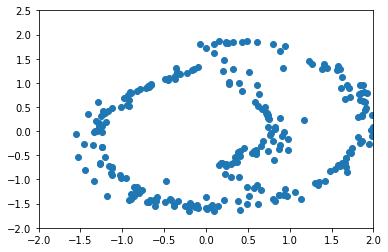

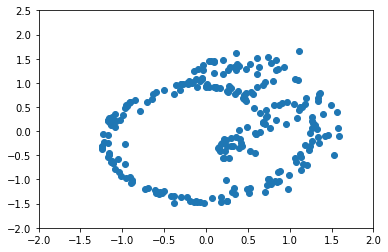

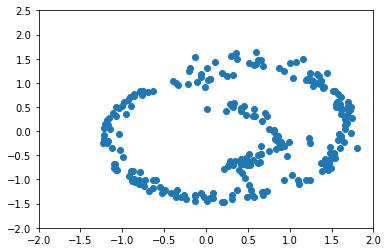

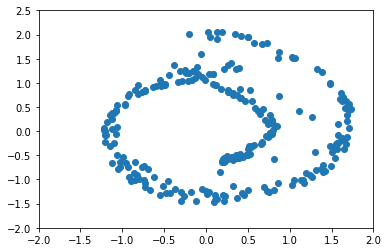

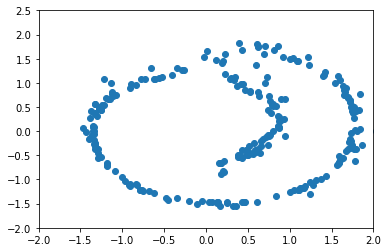

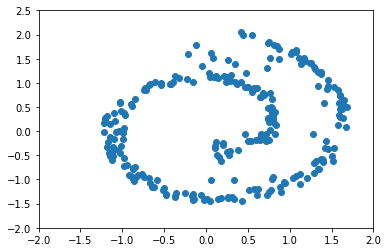

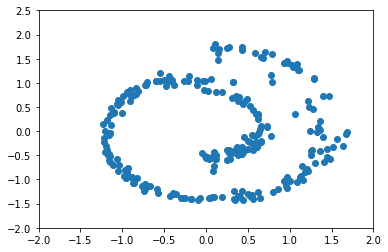

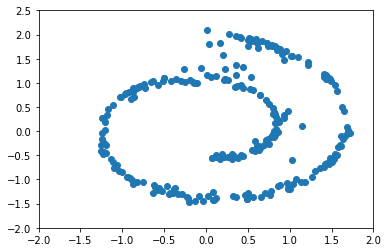

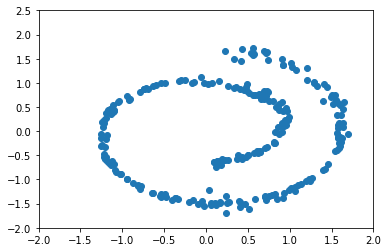

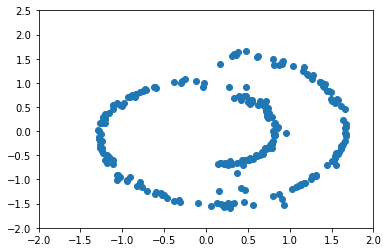

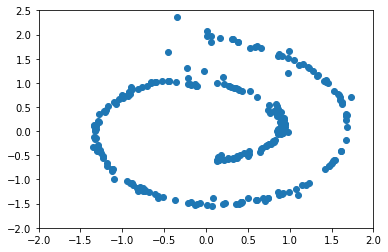

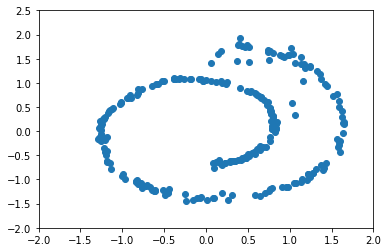

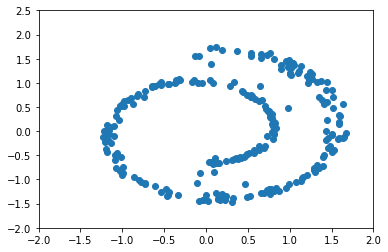

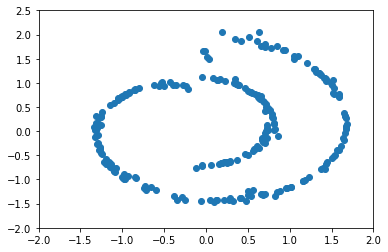

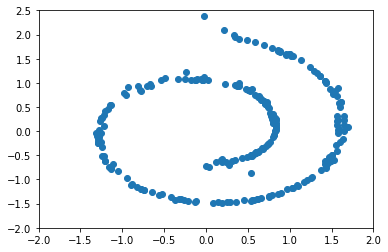

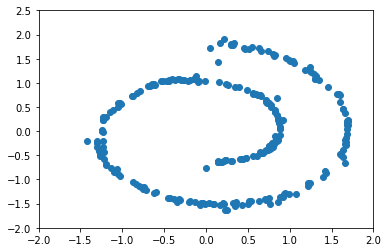

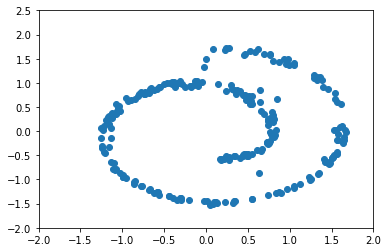

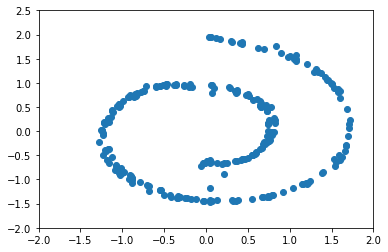

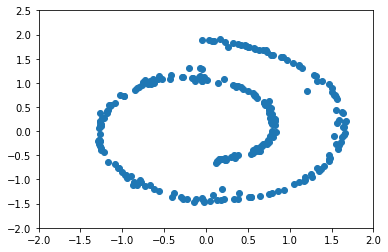

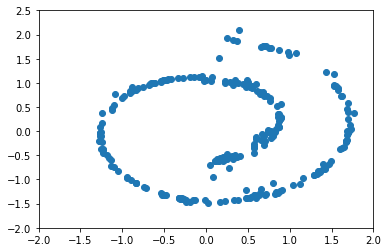

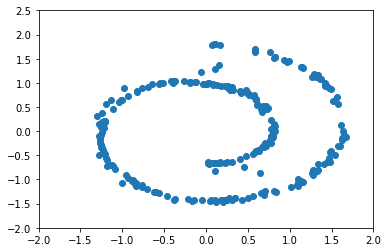

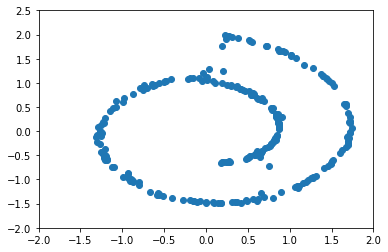

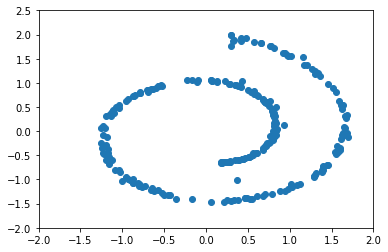

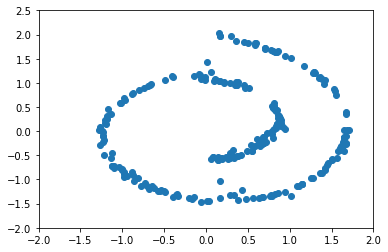

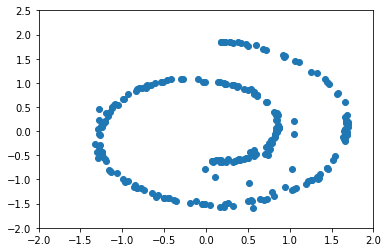

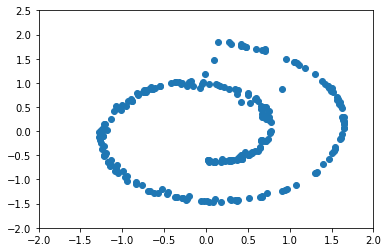

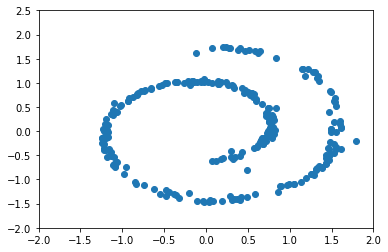

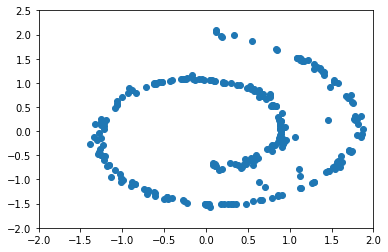

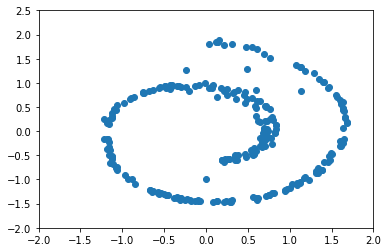

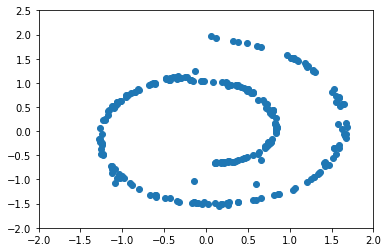

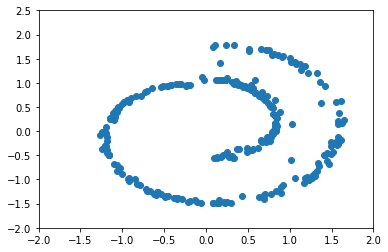

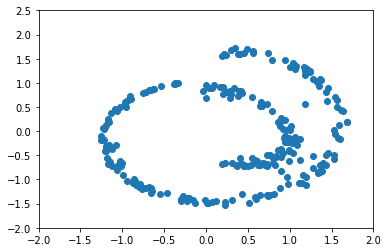

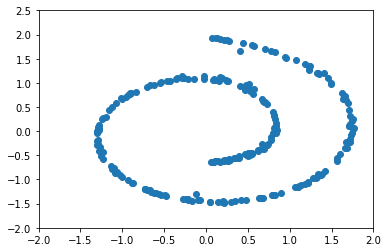

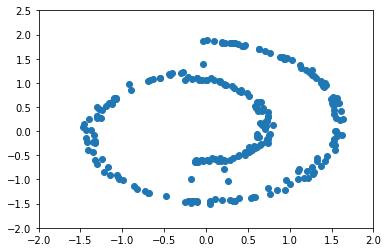

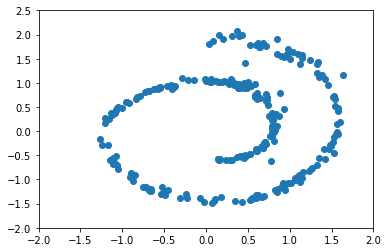

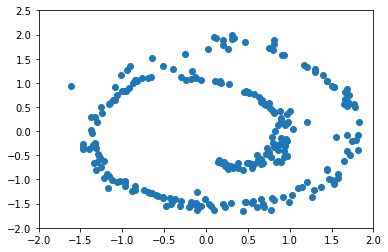

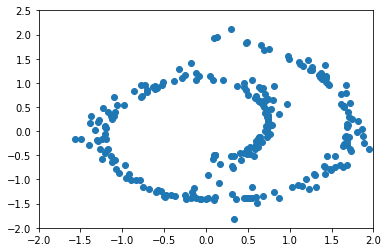

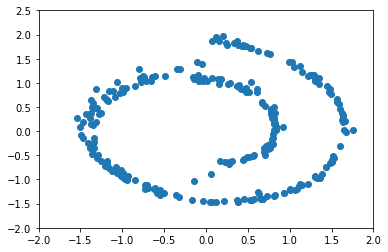

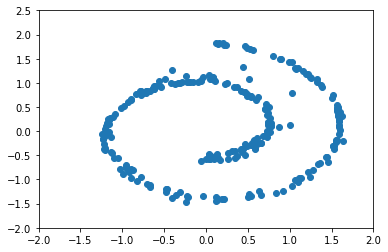

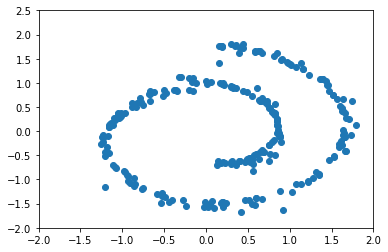

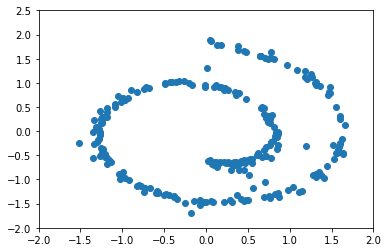

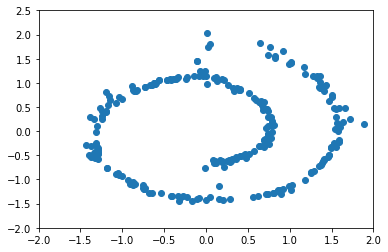

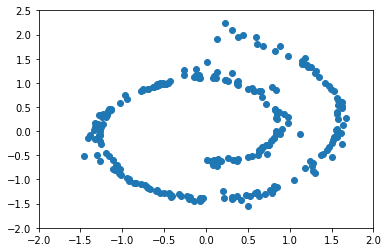

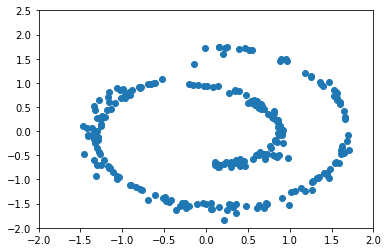

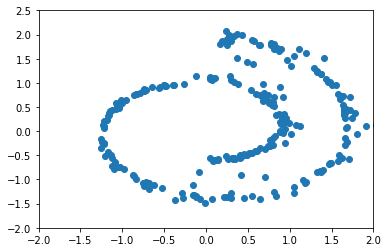

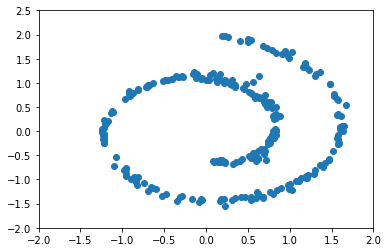

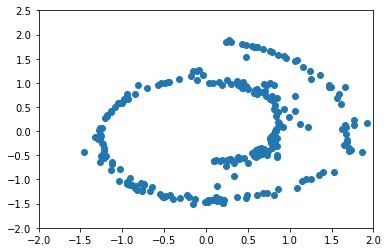

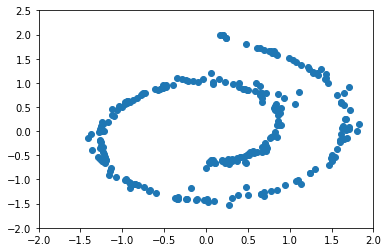

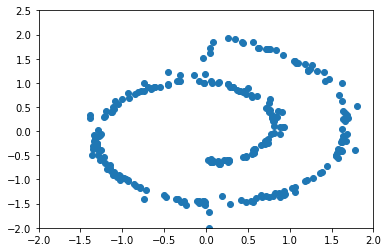

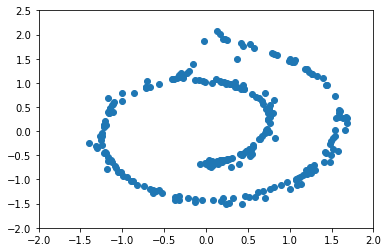

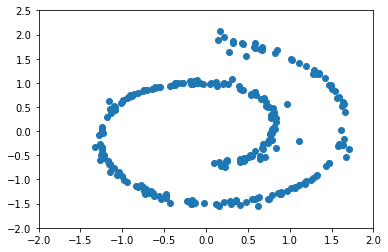

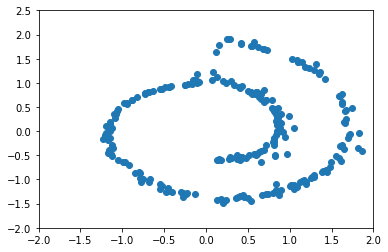

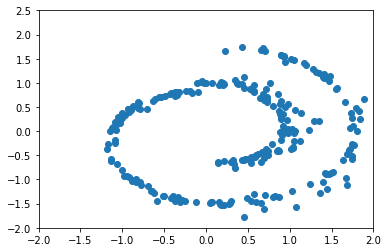

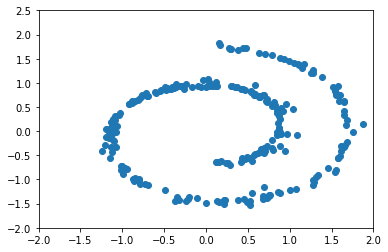

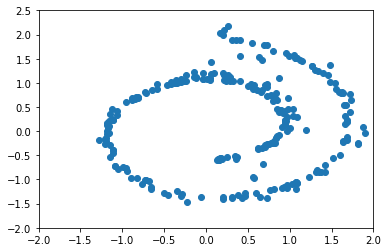

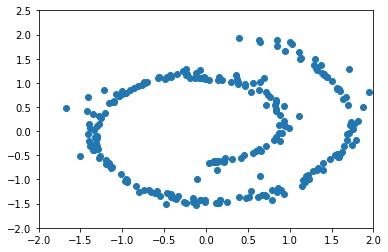

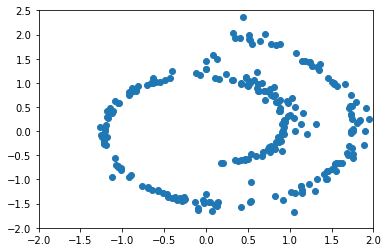

In [60]:
for i in range(len(generations)):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(generations[i][:, 0], generations[i][:, 1])
    plt.savefig(fname = "./wgan-again/"+str(i)+".png")
    plt.xlim(-2, 2)
    plt.ylim(-2, 2.5)
    plt.show()

In [62]:
save_path = saver.save(session, "wgan-again/chpt/SwissRollWGAN.ckpt")

In [ ]:
probs = session.run(disc_fake)